In [177]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath
import matplotlib
import matplotlib.pyplot as plt

import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

import SimpleTemp
from SimpleTemp import _temperature_scaling
from sklearn.calibration import calibration_curve

sys.path.append(dirname(dirname(realpath(os.getcwd()))))


In [178]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [179]:
logpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.dev_preds")


In [180]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=10)
    return prob_true, prob_pred


In [181]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [6]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })

In [182]:
with open(logpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])

Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [183]:
testpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)

Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [184]:
mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

In [185]:
tp0 = np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

In [208]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return  1/(1 + np.exp(-p))


In [ ]:
z1 = np.array(M1['golds'],dtype = int)
x1_0= np.zeros( shape = [len(M1),2])
x1_0[:,0] = (M1['probs'].to_numpy())
cal_1 = _temperature_scaling((x1_0), z1,.01)  
cal_1

In [195]:
z1 = np.array(M1['golds'],dtype = int)
x1_0= np.zeros( shape = [len(M1),2])
x1_0[:,0] = (M1['probs'].to_numpy())
cal_1 = _temperature_scaling((x1_0), z1,.01)  
cal_1

0.05059069092281358

In [173]:
z2 = np.array(M2['golds'],dtype = int)
x2_0= np.zeros( shape = [len(M2),2])  
x2_0[:,0] = M2['probs'].to_numpy()
cal_2 = _temperature_scaling((x2_0), z2, .1)  
cal_2

0.022882084280683418

In [206]:
z3 = np.array(M3['golds'],dtype = int)
x3_0= np.zeros( shape = [len(M3),2])  
x3_0[:,0] = M3['probs'].to_numpy()
cal_3 = _temperature_scaling((x3_0), z3, .5)  
cal_3

0.012714146301556865

In [207]:
z4 = np.array(M4['golds'],dtype = int)
x4_0= np.zeros( shape = [len(M4),2])  
x4_0[:,0] = M4['probs'].to_numpy()
cal_4 = _temperature_scaling((x4_0), z4, .07)  
cal_4

0.011115373959432674

In [203]:
calibrated_test_logit_1 =  logit_trans(tp1)* cal_1

(array([ 280.,  601.,  989., 1444., 2009., 2728., 3365., 3013., 1437.,
         159.]),
 array([-0.20710009, -0.18661297, -0.16612584, -0.14563872, -0.12515159,
        -0.10466447, -0.08417734, -0.06369022, -0.04320309, -0.02271597,
        -0.00222884]),
 <BarContainer object of 10 artists>)

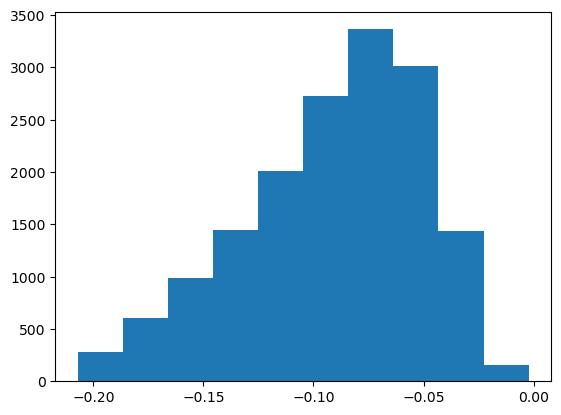

In [204]:
plt.hist( calibrated_test_logit_1)

(array([ 285.,  600., 1002., 1446., 2022., 2733., 3361., 2997., 1420.,
         159.]),
 array([0.44840924, 0.4535126 , 0.45861595, 0.46371931, 0.46882266,
        0.47392602, 0.47902937, 0.48413272, 0.48923608, 0.49433943,
        0.49944279]),
 <BarContainer object of 10 artists>)

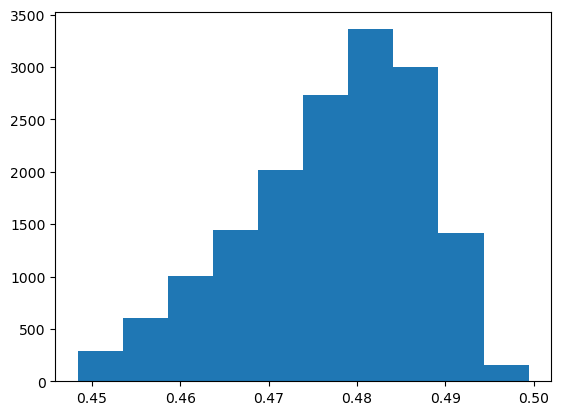

In [205]:
plt.hist( 1/ ( 1 + np.exp(-calibrated_test_logit_1)))

In [133]:
cal_p1 =  M1['probs'].to_numpy()/cal_1 
cal_p2 =  M2['probs'].to_numpy()/cal_2 
cal_p3 =  M3['probs'].to_numpy()/cal_3 
cal_p4 =  M4['probs'].to_numpy()/cal_4 

In [158]:
cali1 = 1/(1+ np.exp(cal_p1))
cali2 = 1/(1+ np.exp(cal_p2))
cali3 = 1/(1+ np.exp(cal_p3))
cali4 = 1/(1+ np.exp(cal_p4))

In [159]:
#cali1 = M1['probs']
#cali2 = M2['probs']
#cali3 = M3['probs']
#cali4 = M4['probs']

In [160]:
y1, p1 = compute_calibration_curve(z1, np.clip(cali1 ,0,1))
y2, p2 = compute_calibration_curve(z2, np.clip(cali2 ,0,1))
y3, p3 = compute_calibration_curve(z3,np.clip(cali3 ,0,1))
y4, p4 = compute_calibration_curve(z4, np.clip(cali4 ,0,1))


In [161]:
def plotter (p_i, y_i):
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

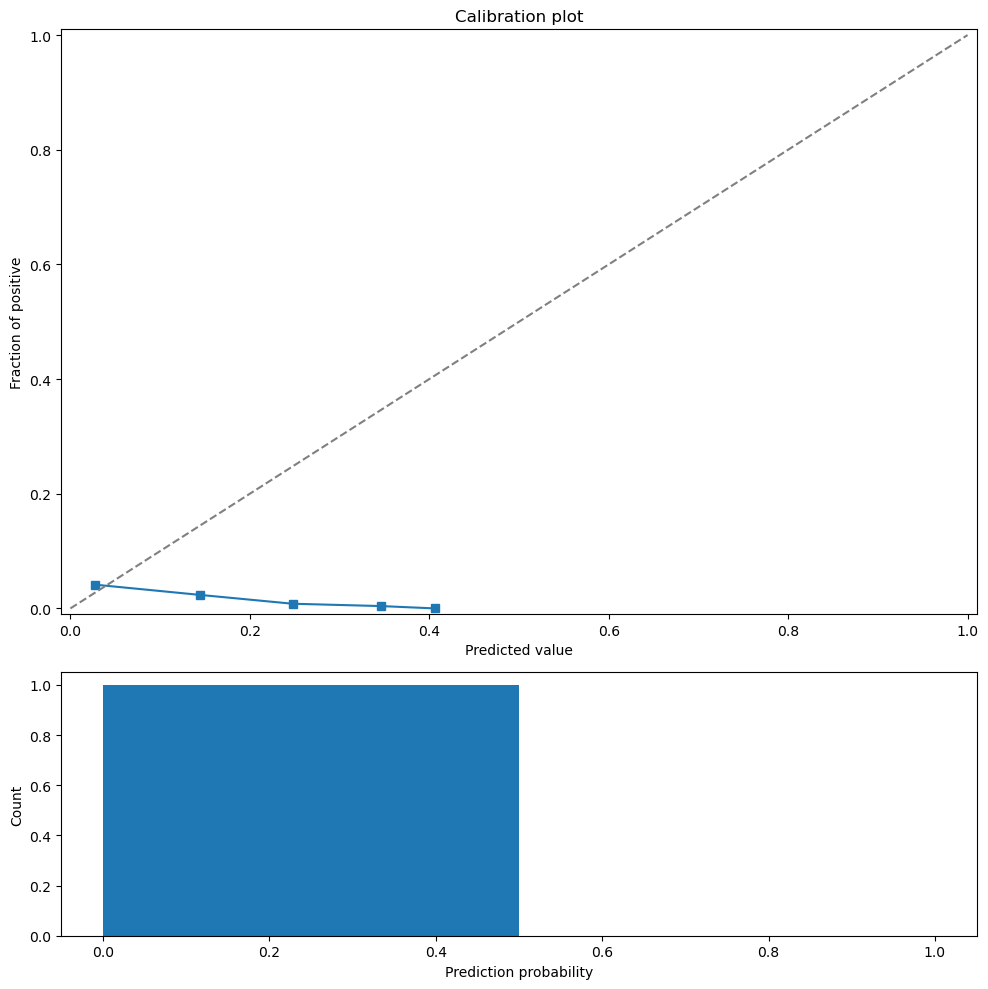

In [162]:
plotter(p1, y1)

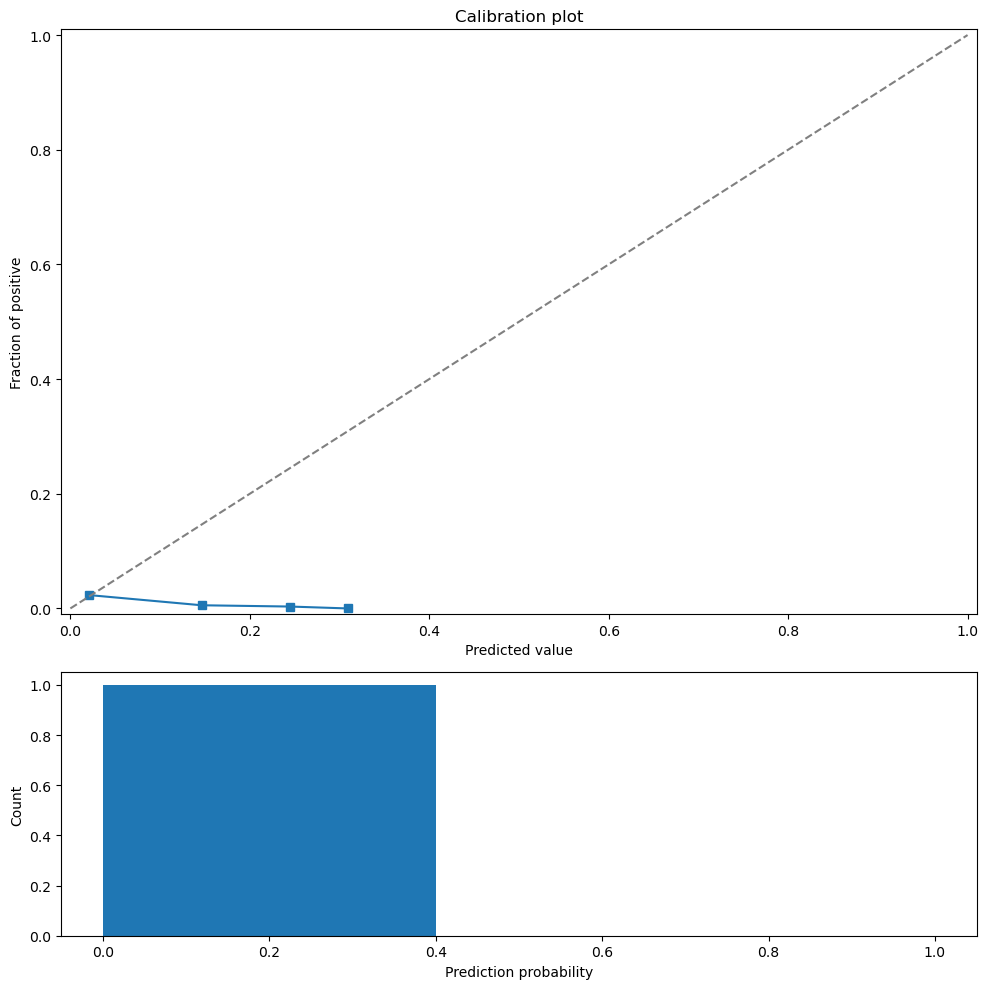

In [163]:
plotter(p2, y2)

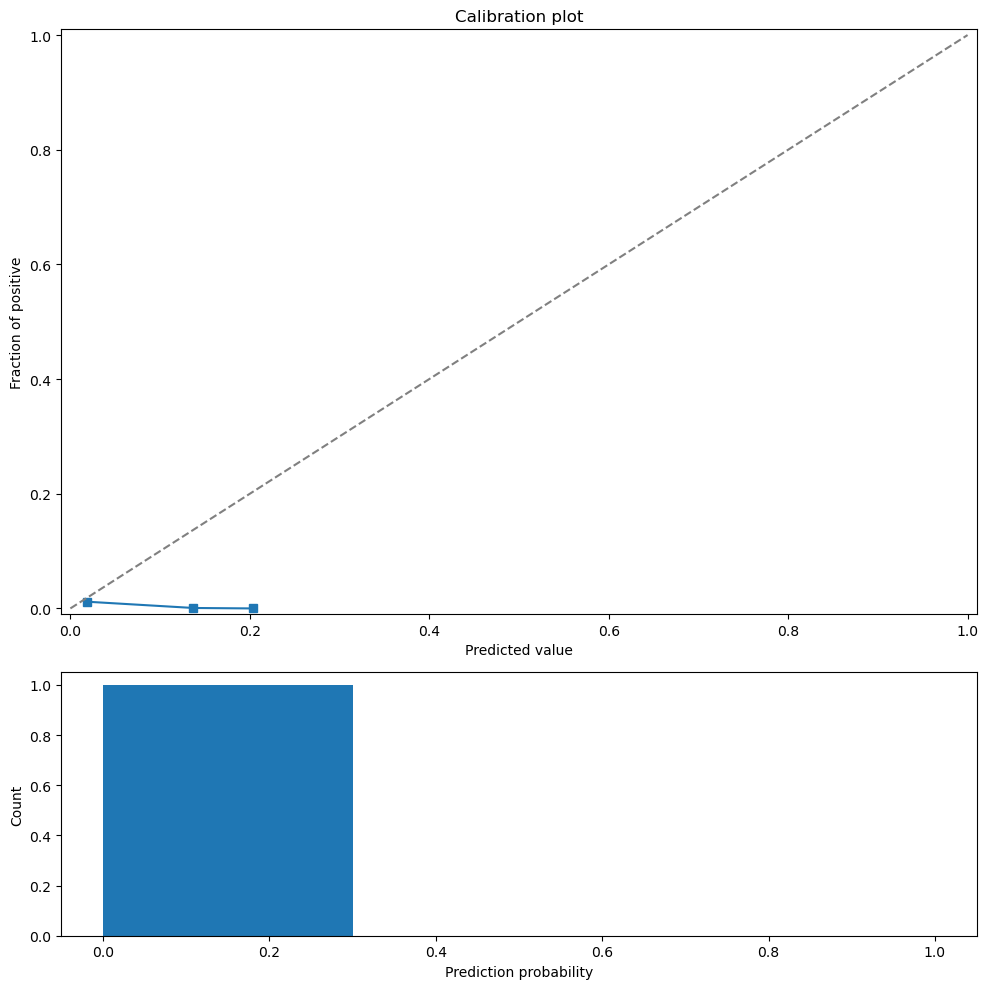

In [164]:
plotter(p3, y3)

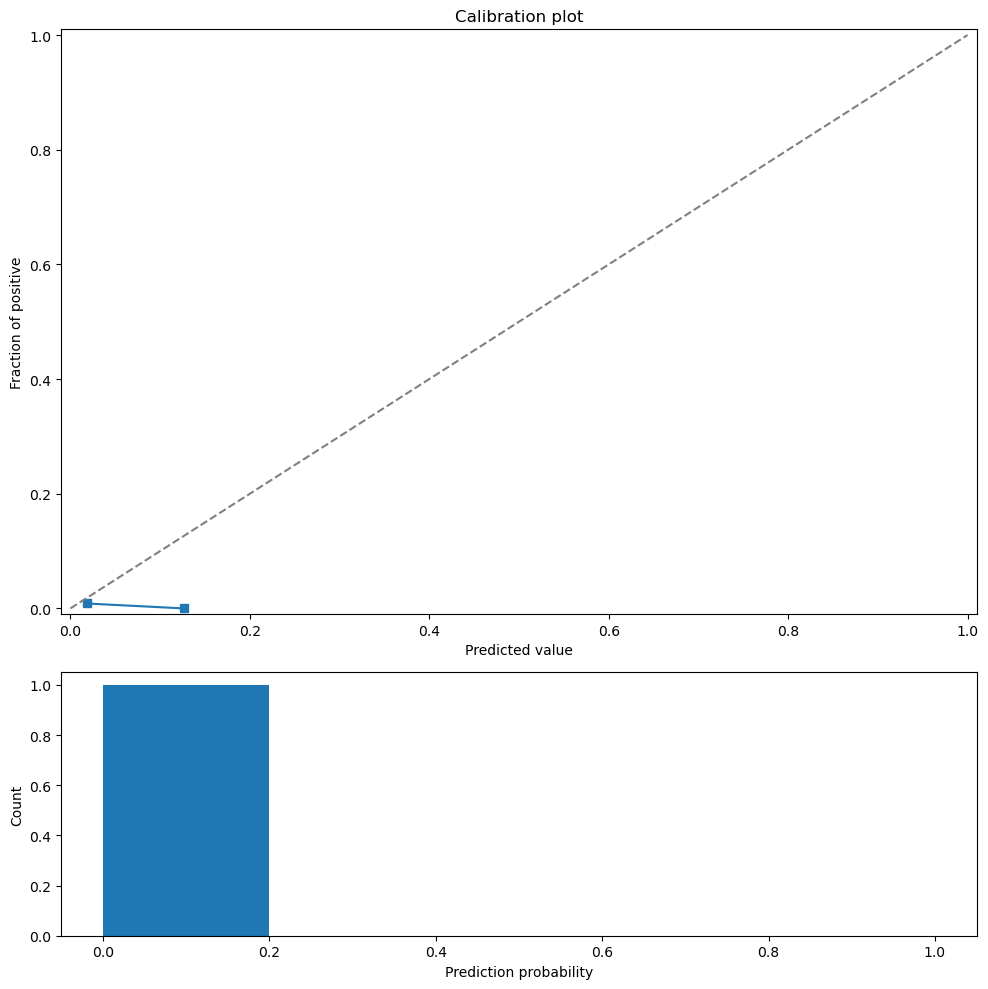

In [165]:
plotter(p4, y4)

(array([2451., 2792., 2698., 2569., 2145., 1737., 1021.,  459.,  146.,
          11.]),
 array([0.01589061, 0.06250444, 0.10911827, 0.1557321 , 0.20234593,
        0.24895976, 0.29557359, 0.34218742, 0.38880124, 0.43541507,
        0.4820289 ]),
 <BarContainer object of 10 artists>)

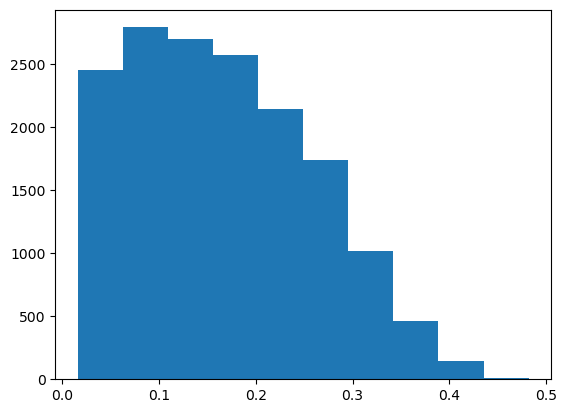

In [53]:
plt.hist( M1['probs'].to_numpy())

In [ ]:
sklearn.metrics.roc_auc_score(m1['outcome'],  m1['p6'], average = 'samples')


0.5600783435183764

In [ ]:
( confusion_matrix (m1['outcome'],  m1['p6']>.5) )

array([[72681,     5],
       [ 4301,     0]], dtype=int64)

In [ ]:
# how many people had event within 6 months of index date

In [27]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 